# CPSC-5616EL: Convolutional Neural Networks

Here's a simple example of a Convolutional Neural Network (CNN) using PyTorch. In this example, we'll create a CNN for image classification using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) (Canadian Institute For Advanced Research). The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define a CNN model and move it to the GPU
# 2 convolution layers (maxpool and relu) + 2 fully connected layers (including output layer)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the architecture of the neural network
        # Convolutional Layer 1: Input channels=3 (RGB), Output channels=32 (diff. filter), Kernel size=3x3, Padding=1
        # The neural network learns these weights for 32 features through backpropagation during training
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # output = 32 feature maps
        # Convolutional Layer 2: Input channels=32, Output channels=64 (increase the features), Kernel size=3x3, Padding=1
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # output = 64 feature maps
        # Max Pooling Layer: Kernel size=2x2, Stride=2 (pooling window moves horizontally and vertically after each operation)
        self.pool = nn.MaxPool2d(2, 2) # now the image is 8x8: 2 times of maxpooling from 32x32 to 16x16 then to 8x8
        # Fully Connected Layer 1: Input features=64*8*8 (output channels * output image size), Output features=128
        # Assume number of output features is selected empirically based on experiments (you can freely choose the output features number)
        self.fc1 = nn.Linear(64 * 8 * 8, 128) # output = 128 features
        # Fully Connected Layer 2 (Output Layer): Input features=128, Output features=10 (number of classes)
        self.fc2 = nn.Linear(128, 10) # output = 10 classes

    def forward(self, x):
        # Forward pass through the network
        # Convolutional Layer 1 followed by ReLU activation and max pooling
        x = self.pool(torch.relu(self.conv1(x)))
        # Convolutional Layer 2 followed by ReLU activation and max pooling
        x = self.pool(torch.relu(self.conv2(x)))
        # Reshape the tensor for the fully connected layers
        x = x.view(-1, 64 * 8 * 8)
        # Fully Connected Layer 1 followed by ReLU activation
        x = torch.relu(self.fc1(x))
        # Fully Connected Layer 2 (Output Layer)
        x = self.fc2(x)

        return x

# Create an instance of the CNN model and move it to the GPU
net = Net().to(device)

# Define the loss function (Cross Entropy Loss for classification problems)
criterion = nn.CrossEntropyLoss()
# Define the optimizer (Stochastic Gradient Descent with momentum)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# Load and preprocess the CIFAR-10 dataset
# a normalized PyTorch tensor that can be passed as input
# torchvision.transforms.Normalize(mean, std, inplace=False)
# Suppose you have a pixel value of (100, 150, 200) for a particular pixel in an image.
# After applying this normalization, the pixel values would be transformed as follows:
# Red channel: (100 - 0.5) / 0.5 = 199
# Green channel: (150 - 0.5) / 0.5 = 299
# Blue channel: (200 - 0.5) / 0.5 = 399
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Training loop
for epoch in range(5):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Move data to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = net(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss CE
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}")

print("Finished Training")

# Save the trained model
torch.save(net.state_dict(), 'cifar10_model.pth')


Using device: cuda


100%|██████████| 170M/170M [00:04<00:00, 34.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch 1, Loss: 1.5239516698643374
Epoch 2, Loss: 1.06810214604868
Epoch 3, Loss: 0.8866599236455415
Epoch 4, Loss: 0.7488110236194737
Epoch 5, Loss: 0.6376154840830952
Finished Training


In [ ]:
import torch
import torchvision.transforms as transforms

# Load the trained model
net = Net()
net.load_state_dict(torch.load('cifar10_model.pth', map_location=torch.device('cpu')))  # Load the model (CPU)

# Set the model to evaluation mode
net.eval()

# Define the class labels for CIFAR-10
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a transformation to preprocess test images,
# a normalized PyTorch tensor that can be passed as input
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Set batch size and create a data loader for the test dataset
batch_size = 64  # You can adjust the batch size as needed
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Initialize variables to track accuracy for each class
class_correct = [0] * 10
class_total = [0] * 10

# Iterate through the test dataset and calculate accuracy for each class
with torch.no_grad():
    for data in testloader:
        images, labels = data
        batch_size = labels.size(0)  # Get the actual batch size for this iteration
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)

        # Calculate accuracy for each class
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

# Print the accuracy for each class
for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f'Accuracy for class {class_labels[i]}: {accuracy:.2f}%')


<ipython-input-2-0d24f5fa3d86>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('cifar10_model.pth', map_location=torch.device('cpu')))  # Loa

Files already downloaded and verified
Accuracy for class airplane: 78.50%
Accuracy for class automobile: 87.50%
Accuracy for class bird: 50.20%
Accuracy for class cat: 49.40%
Accuracy for class deer: 74.20%
Accuracy for class dog: 62.00%
Accuracy for class frog: 83.10%
Accuracy for class horse: 78.20%
Accuracy for class ship: 84.40%
Accuracy for class truck: 74.10%


# Webcam
Adding your local webcam to the notebook. Just add the code from `Code snippets` that located on the left panel.

# Deploying the Trained Model

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


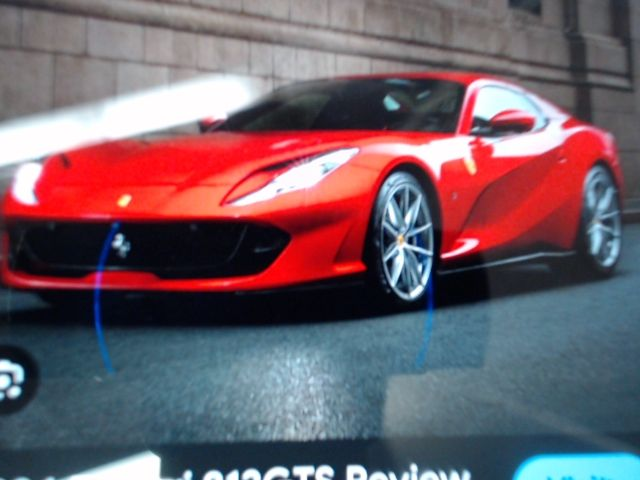

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import torch
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image

# Load the trained model
net = Net()
net.load_state_dict(torch.load('cifar10_model.pth', map_location=torch.device('cpu')))  # Load the model (CPU)

# Set the model to evaluation mode
net.eval()

# Define the class labels for CIFAR-10
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a transformation to preprocess input images,
# a normalized PyTorch tensor that can be passed as input
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),  # Convert to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load and preprocess the input image "photo.jpg"
image = Image.open('photo.jpg')
image = transform(image).unsqueeze(0)  # Add a batch dimension

# Perform inference
with torch.no_grad():
    outputs = net(image)
    probabilities = torch.softmax(outputs, dim=1)

# Print the normalized classification results for all classes
for i in range(len(class_labels)):
    print(f"Probability for class '{class_labels[i]}': {probabilities[0][i].item():.4f}")

# Get the predicted class index and its probability
predicted_class_index = torch.argmax(probabilities, dim=1).item()
predicted_label = class_labels[predicted_class_index]
predicted_probability = probabilities[0][predicted_class_index].item() * 100  # Convert to percentage

# Print the predicted class label and its probability
print(f"Predicted class: {predicted_label}")
print(f"Confidence: {predicted_probability:.2f}%")


Probability for class 'airplane': 0.0000
Probability for class 'automobile': 0.9961
Probability for class 'bird': 0.0000
Probability for class 'cat': 0.0000
Probability for class 'deer': 0.0000
Probability for class 'dog': 0.0000
Probability for class 'frog': 0.0000
Probability for class 'horse': 0.0000
Probability for class 'ship': 0.0009
Probability for class 'truck': 0.0030
Predicted class: automobile
Confidence: 99.61%


<ipython-input-6-c0192ce3d96e>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('cifar10_model.pth', map_location=torch.device('cpu')))  # Loa